# 00 Initial Analysis 

### Load in Data

In [6]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.express as px

In [17]:
# Load in Data
target_ts = '2min.parquet'

cwd = os.getcwd()
meta_data = os.path.join(cwd, "..", "data", "raw_data", "metadata.csv")
time_series = os.path.join(cwd, "..", "data", "raw_data", target_ts)


df_spec = pd.read_csv(meta_data)
df_energy_ldn = pd.read_csv('../data/raw_data/hourly_generation_ldn.csv')
df_energy = pd.read_parquet(time_series)
df_energy

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
1,29.0,2016-12-01 07:42:35+00:00,6125
2,2.0,2016-12-01 07:42:35+00:00,6867
3,4.0,2016-12-01 07:42:36+00:00,3513
4,5.0,2016-12-01 07:42:36+00:00,5660
...,...,...,...
558135319,230.0,2021-09-30 23:55:11+00:00,7830
558135320,2155.0,2021-09-30 23:57:08+00:00,7759
558135321,231.0,2021-09-30 23:57:11+00:00,7830
558135322,2290.0,2021-09-30 23:59:08+00:00,7759


In [87]:
df_energy_ldn.rename(columns={'datetime': 'timestamp'}, inplace=True)
df_energy_ldn.timestamp = pd.to_datetime(df_energy_ldn.timestamp)

,generation_wh,timestamp,ss_id


In [25]:
# Filtering out by hourly intervals only(only use on 2 min)
df_energy = df_energy[(df_energy['timestamp'].dt.minute == 0) & (df_energy['timestamp'].dt.second == 0)]
len(df_energy)

132638

In [26]:
# Merge full dataset
df_merged = pd.merge(df_energy_ldn,df_spec,how='left',on='ss_id')
df_merged['formatted_timestamp'] = df_merged['timestamp'].dt.strftime('%Y-%m-%dT%H:%M')
len(df_merged)

2100888

In [27]:
# filter for london properties only
london_lat_range = (51.28, 51.69)  # Latitude range for Greater London
london_lon_range = (-0.51, 0.30) 

# Filter the DataFrame for london properties
df_merged_ldn = df_merged[(df_merged['latitude_rounded'].between(*london_lat_range)) & (df_merged['longitude_rounded'].between(*london_lon_range))]
len(df_merged_ldn)

2100888

In [28]:
df_merged_ldn.ss_id.unique()

array([ 7344,  7035,  7173,  7158,  6871,  6780,  6929,  6609,  6616,
        2729,  2783,  2786,  3805,  3435,  3470,  3021,  3271,  3281,
        3239,  3087,  3086, 13387,  7060, 27057, 26999, 26976, 26967,
       26972, 26975, 27000, 27035, 27046, 27049, 27008, 27020, 26881,
       26862, 26868, 26859, 26947, 26858, 26802, 26775, 26854, 26810,
       26924])

---

### Data Exploration

In [29]:
len(df_energy)

132638

In [30]:
# unique properties
df_energy.ss_id.nunique()

1380

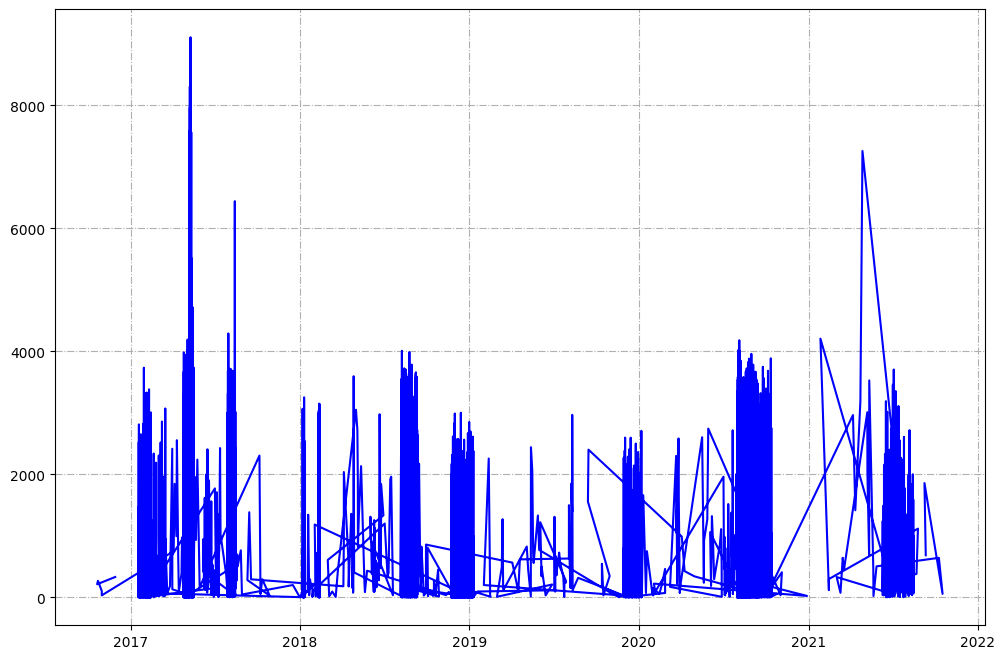

In [31]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(df_energy['timestamp'], df_energy['generation_w'], 'b')

In [32]:
df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [33]:
import plotly.express as px

# Define a function to check if a location is in London
def is_in_london(latitude, longitude):
    # Replace the conditions with the actual latitude and longitude boundaries of London
    london_latitude_range = (51, 52)
    london_longitude_range = (-1, 0.5)
    return (london_latitude_range[0] <= latitude <= london_latitude_range[1]) and (london_longitude_range[0] <= longitude <= london_longitude_range[1])

# Create a new column indicating whether each location is in London
df_spec['in_london'] = df_spec.apply(lambda row: is_in_london(row['latitude_rounded'], row['longitude_rounded']), axis=1)

# Create the scatter plot, coloring the circles differently for locations in London
fig = px.scatter_geo(df_spec, lat=df_spec['latitude_rounded'], lon=df_spec['longitude_rounded'],
                     color='in_london',  # Use the 'in_london' column for coloring
                     scope="europe", projection="natural earth",
                     center={'lat': 54, 'lon': -2})  # Center the map on the UK

fig.update_geos(
    fitbounds="locations",  # Adjust the map boundaries to fit all the data points
    visible=True)  # Set land outlines to be visible

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Set all margins to zero
    plot_bgcolor='black',  # Set plot background color to black
    paper_bgcolor='black'  # Set paper background color to black
)

fig.show()


In [19]:
# Test the weather API
import requests
import pandas as pd 

base_url = 'https://archive-api.open-meteo.com/v1/archive'

params = {
	"latitude": 52.52, # from df_spec
	"longitude": 13.41, # from df_spec
	"start_date": "2016-10-25", # from timeseries 
	"end_date": "2016-10-25", # from timeseries
	"timezone": "Europe/London", # default for london
	"hourly": ["weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant"]       
     }

responses = requests.get(base_url, params).json()

df = pd.DataFrame({
    'time': responses['hourly']['time'],
    # 'weather_code': responses['hourly']['weather_code'],
    # 'shortwave_radiation': responses['hourly']['shortwave_radiation']
    # ... continue with remaining
    })

df.head(5)


,time
0,2016-10-25T00:00
1,2016-10-25T01:00
2,2016-10-25T02:00
3,2016-10-25T03:00
4,2016-10-25T04:00


In [20]:
# looping through hourly params and appending to df
for param in params['hourly']:
    df[param] = responses['hourly'][param]

df.head(10)

,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-10-25T05:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-10-25T06:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.8
7,2016-10-25T07:00,53,6.0,0.0,6.0,0.0,6.0,111.9,11.1,0.0,11.1,0.0,8.0,207.3
8,2016-10-25T08:00,51,20.0,0.0,20.0,0.0,20.0,292.4,25.4,0.0,25.4,0.0,25.4,371.8
9,2016-10-25T09:00,3,73.0,1.0,72.0,3.2,73.0,437.1,82.7,1.1,81.5,3.2,82.7,494.9


In [21]:
# Get definitiion for weather WMO codes
from IPython.display import Image

wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'
wmo_description = requests.get(wmo_url).json()

image = wmo_description['0']['day']['image']
Image(image)
print(wmo_description['0']['day']['description'])
df.head(5)

Sunny


,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Define a function to map weather codes to descriptions
def get_weather_description(weather_code):
    return wmo_description[str(weather_code)]['day']['description']

# Apply the function to create a new column with descriptions
df['description'] = df['weather_code'].apply(get_weather_description)

df.head(5)

,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,description
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Drizzle
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle


# 01 Defining Sample Set

In [38]:
sample_id = 7344

df_merged_sample = df_merged_ldn[df_merged_ldn.ss_id == sample_id]
print(len(df_merged_sample))

73008

In [41]:
df_merged_sample.head()

,generation_wh,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,formatted_timestamp
0,100.00,2015-05-31 16:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T16:00
36,82.58,2015-05-31 17:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T17:00
48,0.00,2015-05-31 18:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T18:00
70,0.00,2015-05-31 19:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T19:00
103,0.00,2015-05-31 20:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T20:00


In [42]:
# find min date
print(min(df_merged_sample['timestamp']).date())

# find max date
print(max(df_merged_sample['timestamp']).date())

# legth of df_merged_sample
print(f'no. of rows : {len(df_merged_sample)}')

# call api with these dates and hourly then write to json file for offline chache

2013-04-18
2021-09-30
no. of rows : 73008


In [43]:
print(min(df_energy['timestamp']).date())
print(max(df_energy['timestamp']).date())
# legth of df_merged
print(f'no. of rows : {len(df_merged)}')
print(f'no. of rows : {len(df_merged_ldn)}')

2016-10-20
2021-10-16
no. of rows : 2100888
no. of rows : 2100888


# 02 Single Row Test

In [ ]:
# create one row test
import requests
import pandas as pd 

df_merged_single = df_merged_sample.head(1)
base_url = 'https://archive-api.open-meteo.com/v1/archive'

params = {
        "latitude": df_merged_single['latitude_rounded'],
        "longitude": df_merged_single['longitude_rounded'],
        "start_date": df_merged_single['timestamp'].iloc[0].date(),
        "end_date": df_merged_single['timestamp'].iloc[0].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

response = requests.get(base_url, params)
data = response.json()
hourly_weather = data['hourly']['weather_code']
hourly_time = data['hourly']['time']

wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'
wmo_description = requests.get(wmo_url).json()

for index, time in enumerate(hourly_time):
        #ensure you extract the string value and not just the series with .iloc[0]
        if time == df_merged_single['formatted_timestamp'].iloc[0]:
            weather_result = hourly_weather[index]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            print(f'weather description: {weather_description}')


# 03 Mulitple row sample set

In [ ]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged_sample.head(10)

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

for index, row in df_merged_multiple.iterrows():
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

    response = requests.get(base_url, params)
    data = response.json()
    hourly_weather = data['hourly']['weather_code']
    hourly_time = data['hourly']['time']

    wmo_description = requests.get(wmo_url).json()

    for i, time in enumerate(hourly_time):
        # Ensure you extract the string value and not just the series with .iloc[0]
        if time == row['formatted_timestamp']:
            weather_result = hourly_weather[i]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            print(f'weather description for row {index + 1}: {weather_description}')


# 04 Apply Full Sample Set

In [ ]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

def get_weather_description(row):
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

    response = requests.get(base_url, params)
    data = response.json()
    hourly_weather = data['hourly']['weather_code']
    hourly_time = data['hourly']['time']

    wmo_description = requests.get(wmo_url).json()

    for i, time in enumerate(hourly_time):
        # Ensure you extract the string value and not just the series with .iloc[0]
        if time == row['formatted_timestamp']:
            weather_result = hourly_weather[i]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            return weather_description

# Apply the function to create a new column 'weather_description'
df_merged_multiple['weather_description'] = df_merged_multiple.apply(get_weather_description, axis=1)

df_merged_multiple.head(5)


# 05 Call remaining API features

In [ ]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged_sample.head(10)

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

def get_solar_feature(row, param):
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": [param]       
    }

    response = requests.get(base_url, params)
    data = response.json()
    solar_feature = data['hourly'][param]
    hourly_time = data['hourly']['time']

    for i, time in enumerate(hourly_time):
        if time == row['formatted_timestamp']:
            return solar_feature[i] 

# Apply the function to create a new column 'weather_description'

hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant"]       

for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param), axis=1)

# 06 API DUMP JSON

### For loop option (API DUMP)

In [ ]:
# calling from API dump instead of online call
import pandas as pd 

def get_solar_feature(row, param):

    data = pd.read_json('../data/raw_data/api_data.json')
    solar_feature = data['hourly'][param]
    hourly_time = data['hourly']['time']

    for i, time in enumerate(hourly_time):
        if time == row['formatted_timestamp']:
            return solar_feature[i] 

# Apply the function to create a new column 'weather_description'

hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant", "is_day", "sunshine_duration"]

for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param), axis=1)

In [ ]:
df_merged_multiple.head()

### Vecorization optimised (API DUMP)

In [44]:
# optimising with vectorization instead of for loop
import pandas as pd
import numpy as np

# Convert 'formatted_timestamp' to datetime if it's not already in that format
df_merged_ldn['formatted_timestamp'] = pd.to_datetime(df_merged_ldn['formatted_timestamp'])

def get_solar_feature(row, param):
    data = pd.read_json('../data/raw_data/api_data.json')
    solar_feature = data['hourly'][param]
    hourly_time = pd.to_datetime(data['hourly']['time'])

    idx = np.where(hourly_time == row['formatted_timestamp'])[0]
    if len(idx) > 0:
        return solar_feature[idx[0]]
    else:
        return np.nan

# Apply the function to create new columns
hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation"]

for param in hourly_params:
    df_merged_ldn[param] = df_merged_ldn.apply(lambda row: get_solar_feature(row, param), axis=1)

KeyboardInterrupt: 

In [ ]:
df_merged_multiple.head(5)

### Calling API in range of property dates 🏠

In [88]:
# Apply the function to create new columns
hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation"]


# create get solar feature function which filters matching timeframe
def get_solar_feature(row, param, data):
    
    solar_feature = data['hourly'][param]
    hourly_time = pd.to_datetime(data['hourly']['time'])

    idx = np.where(hourly_time == row['formatted_timestamp'])[0]
    if len(idx) > 0:
        return solar_feature[idx[0]]
    else:
        return np.nan

In [89]:
id_list = df_merged_ldn.ss_id.unique()
id_list

array([ 7344,  7035,  7173,  7158,  6871,  6780,  6929,  6609,  6616,
        2729,  2783,  2786,  3805,  3435,  3470,  3021,  3271,  3281,
        3239,  3087,  3086, 13387,  7060, 27057, 26999, 26976, 26967,
       26972, 26975, 27000, 27035, 27046, 27049, 27008, 27020, 26881,
       26862, 26868, 26859, 26947, 26858, 26802, 26775, 26854, 26810,
       26924])

### Iterating through properties

In [272]:
# Wrap entire code into for loop to iterate through each property
for id in id_list:
    df_merged_multiple = df_merged_ldn[df_merged_ldn['ss_id']== id]

    # Convert 'formatted_timestamp' to datetime if it's not already in that format
    df_merged_multiple['formatted_timestamp'] = pd.to_datetime(df_merged_multiple['formatted_timestamp'])

    #Get API for specific property
    base_url = 'https://archive-api.open-meteo.com/v1/archive'
    params = {
            "latitude": df_merged_multiple['latitude_rounded'],
            "longitude": df_merged_multiple['longitude_rounded'],
            "start_date": min(df_merged_multiple['timestamp']).date(),
            "end_date": max(df_merged_multiple['timestamp']).date(),
            "timezone": "Europe/London",
            'hourly' : hourly_params
        }
    # response = requests.get(base_url, params)
    # data = response.json()[0]
    data = pd.read_json('../data/raw_data/ldn_api.json')
    
    # loop through each weather param and populate weather features to DF
    for param in hourly_params:
        df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param, data), axis=1)
    print(f'processed property id:{id}')

    # Export DataFrame to CSV and concatenate
    csv_filename = f"../data/raw_data/ldn_energy_supply.csv"
    if os.path.exists(csv_filename):
        df_merged_multiple.to_csv(csv_filename, mode='a', header=False, index=False)
    else:
        df_merged_multiple.to_csv(csv_filename, index=False)
        
print('--------chunking complete!------')


processed property id:2786
processed property id:6929
processed property id:7035
processed property id:7569
processed property id:13387
processed property id:3435
processed property id:3443
processed property id:2998
processed property id:7118
processed property id:2729
processed property id:2940
processed property id:3281
processed property id:3805
processed property id:6630
processed property id:7171
processed property id:3147
processed property id:7113
processed property id:4029
processed property id:7051
processed property id:7702
processed property id:7258
processed property id:2783
processed property id:6673
processed property id:7329
processed property id:6609
processed property id:6675
processed property id:7052
processed property id:6616
processed property id:4002
processed property id:7344
processed property id:2903
processed property id:3239
processed property id:3085
processed property id:3537
processed property id:3470
processed property id:2657
processed property id:2918


# 07 Building Neural Network Sequential Model 🧠


In [13]:
training_data = pd.read_csv('../data/raw_data/ldn_energy_supply.csv')
training_data = training_data.drop(columns=[
    'ss_id',
    'latitude_rounded',
    'longitude_rounded',
    'tilt',
    'kwp',
    'orientation',
    'weather_code'
])

In [23]:
X = training_data.drop(columns=['generation_w']).select_dtypes(include='number')
y = training_data['generation_w']
X

,temperature_2m,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation
0,13.0,624.0,425.0,199.0,609.1,954.1
1,7.5,656.0,520.0,136.0,783.5,897.4
2,8.0,671.0,455.0,216.0,614.0,1002.0
3,9.0,782.0,612.0,170.0,784.4,1055.0
4,9.7,770.0,596.0,174.0,765.5,1052.6
...,...,...,...,...,...,...
13111,12.2,331.0,127.0,204.0,244.1,714.2
13112,13.3,224.0,145.0,79.0,391.5,508.4
13113,12.2,143.0,86.0,57.0,344.4,342.8
13114,10.6,37.0,13.0,24.0,102.1,144.9


<Axes: >

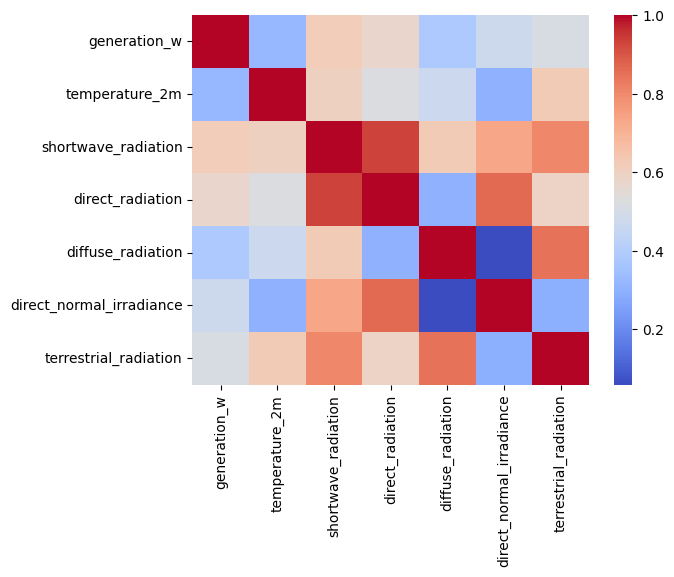

In [280]:
import seaborn as sns
sns.heatmap(pd.DataFrame(training_data.select_dtypes(include='number')).corr(), cmap='coolwarm')

In [281]:
import sklearn
from tensorflow import keras
from keras import layers

def initialize_model():
    ###ARCHITECTURE 01
    model = keras.models.Sequential()
    model.add(layers.Dense(10, activation='relu',input_dim=X.shape[1])) # Input
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(7, activation='relu')) # Hidden
    model.add(layers.Dropout(rate=0.2))  # (optional)
    
    model.add(layers.Dense(7, activation='relu')) # Hidden
    model.add(layers.Dropout(rate=0.2))  # (optional)

    model.add(layers.Dense(1, activation='linear')) # Output

    return model

def compile_model(model, optimizer_name):
    ###COMPILES MODEL 02
    model.compile(loss='mse',
                  optimizer=optimizer_name,
                  metrics=['mae'])

    return model


In [282]:
###01 Load and split data###
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas as pd

df = training_data

X = training_data.drop(columns=['generation_w']).select_dtypes(include='number')
y = training_data['generation_w']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


###02 Build and Train Model###
model = initialize_model()
model = compile_model(model, 'adam')

es = EarlyStopping()

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=1000,
          validation_split=0.3,
          callbacks=[es],
          verbose=0)

###03 Export and evaluate model###
loss, mae = model.evaluate(X_test, y_test, verbose=0)
mae_test = mae

In [283]:
# Predictions on the test set
predictions = model.predict(X_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


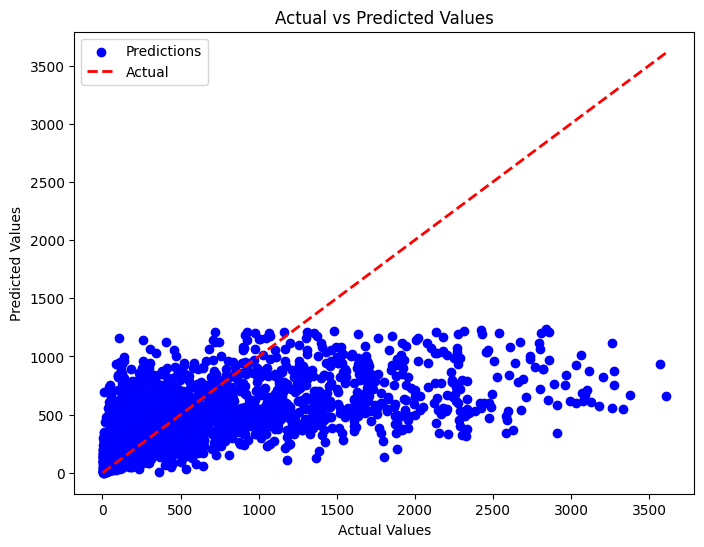

In [284]:
import matplotlib.pyplot as plt

# Plotting predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [285]:
history.history['val_loss']

[289524.65625, 286223.90625, 296387.71875]

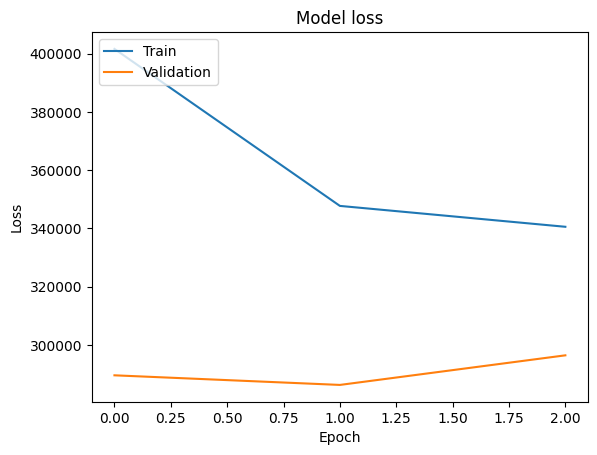

In [286]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


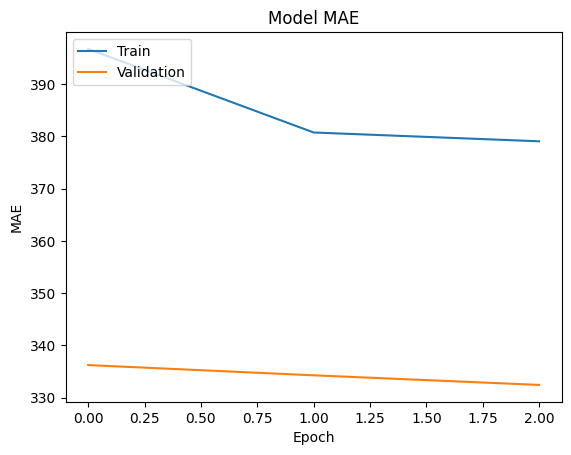

In [287]:
# Plot training & validation MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


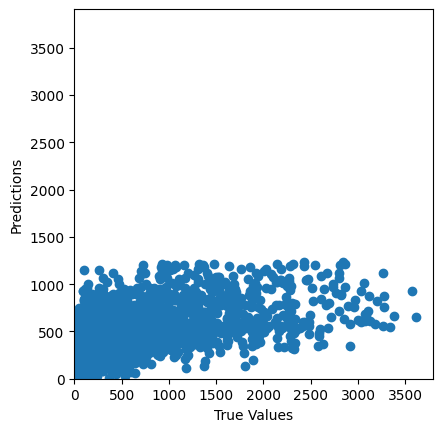

In [288]:
import numpy as np

# Get predictions
predictions = model.predict(X_test)

# Plot predictions vs actual values
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


In [62]:
# Import the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split


# Instantiate the model
model = SGDRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model's performance (e.g., using metrics like MSE, RMSE, R^2)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 8.411656772287494e+26
R-squared: -1.8751175433220055e+21


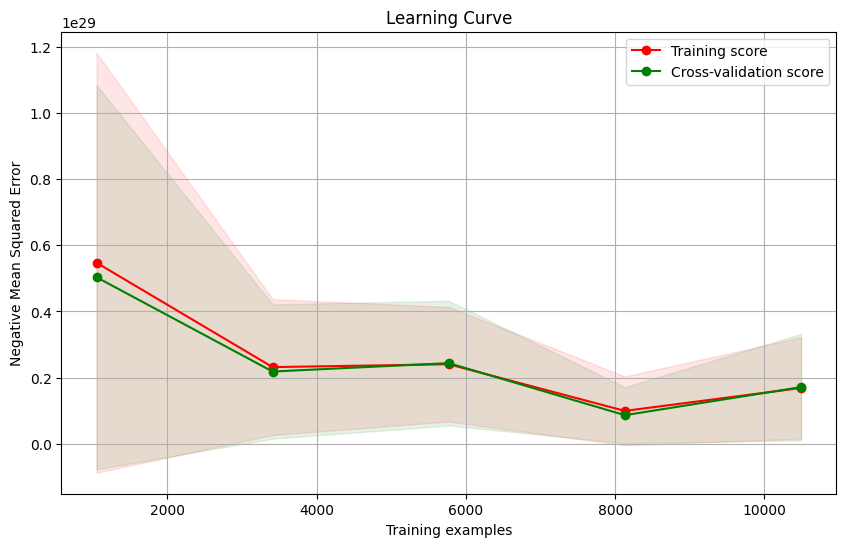

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.xlabel("Training examples")
    plt.ylabel("Negative Mean Squared Error")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curve
plot_learning_curve(model, X, y, cv=5)


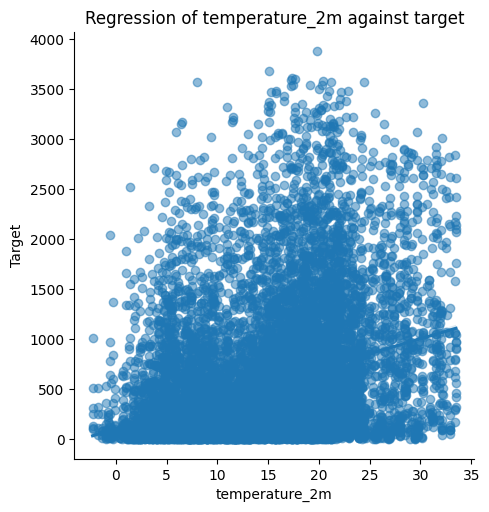

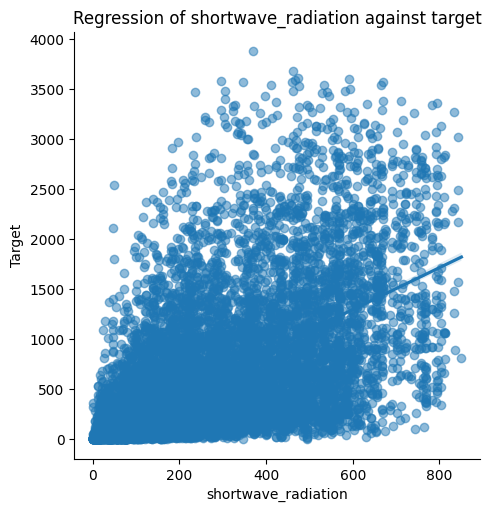

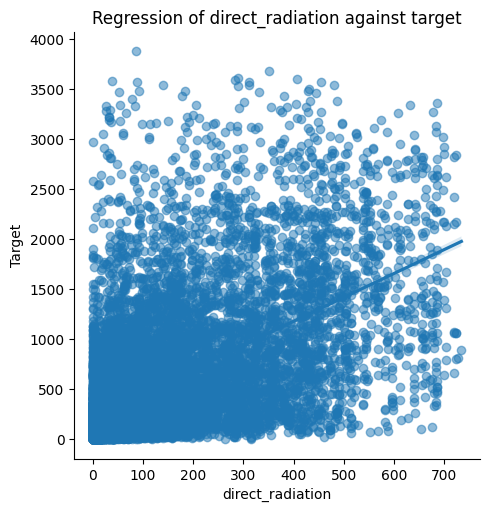

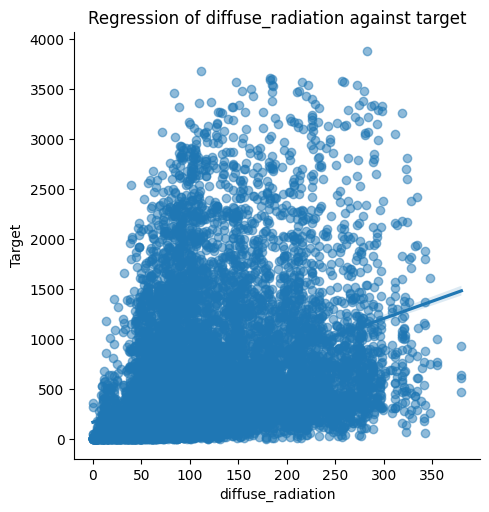

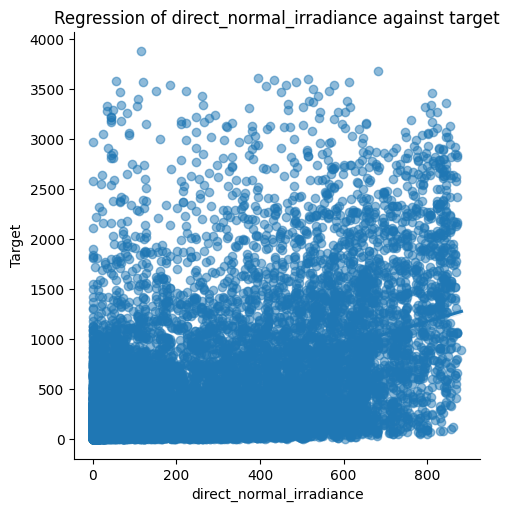

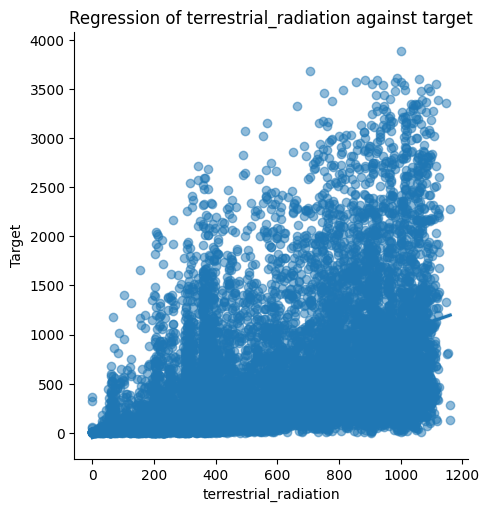

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate through each column in X
for column in X.columns:
    # Plot regression plot for each feature against the target
    sns.lmplot(x=column, y='generation_w', data=training_data, scatter_kws={'alpha':0.5})
    plt.title(f'Regression of {column} against target')
    plt.xlabel(column)
    plt.ylabel('Target')
    plt.show()


# Time Series Model 🕐

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [74]:
# Create DataFrame for Prophet with target, timestamp, and additional features
training_data = df_merged_sample
training_data.rename(columns={'generation_wh': 'y','timestamp': 'ds'}, inplace=True)
training_data.head(3)

,y,ds,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,formatted_timestamp
0,100.00,2015-05-31 16:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T16:00
36,82.58,2015-05-31 17:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T17:00
48,0.00,2015-05-31 18:00:00,7344,51.42,-0.19,E01003458,180.0,35.0,1.52,2013-04-18,2015-05-31T18:00


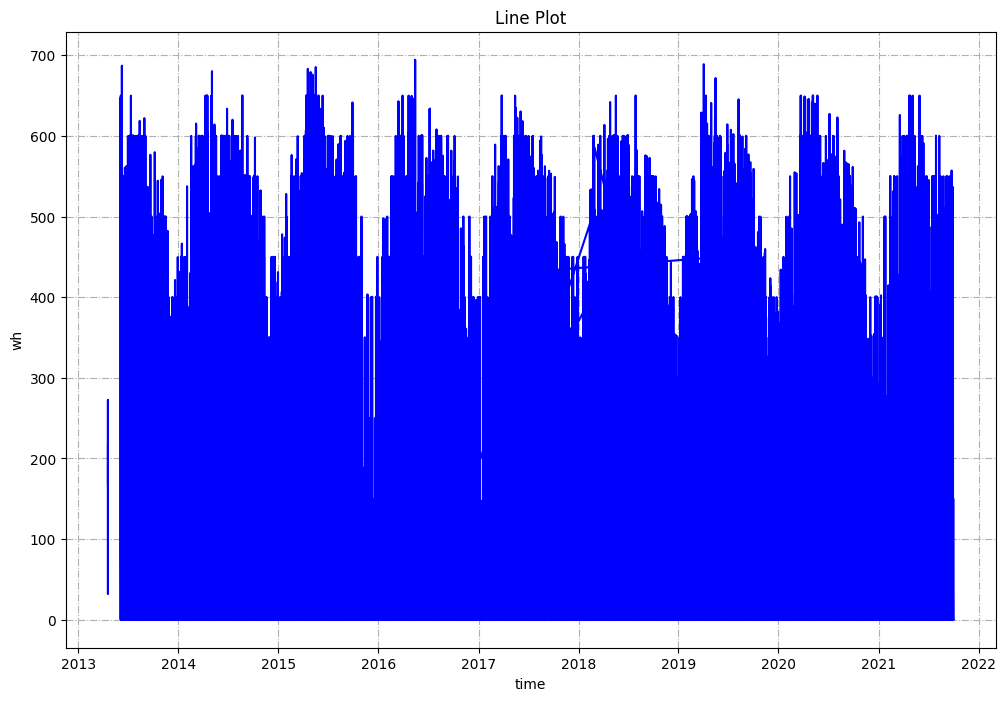

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

# Assuming 'ds' is the x-axis data and 'y' is the y-axis data
plt.plot(training_data['ds'], training_data['y'], color='blue', linestyle='-')

plt.xlabel('time')  # Add x-axis label if necessary
plt.ylabel('wh')  # Add y-axis label if necessary
plt.title('Line Plot')  # Add plot title if necessary
plt.show()


In [80]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_size = 0.8  # 80% train, 20% test
train, test = train_test_split(training_data, test_size=1-train_size, shuffle=False)

# Verify the shapes of the train and test sets
train.shape, test.shape

((58406, 11), (14602, 11))

In [81]:
model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
model.fit(train)

12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Set the number of periods into the future for prediction
horizon = 36

# Create a DataFrame with future timestamps for prediction
future = model.make_future_dataframe(periods=horizon, freq='MS')

# Generate predictions for the future timestamps
forecast = model.predict(future)

# Display the last few rows of the forecast DataFrame, including timestamps and predicted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
58095,2024-05-01 23:00:00,2.919376,-274.019036,267.868519
58096,2024-06-01 23:00:00,2.053573,-225.467288,230.234912
58097,2024-07-01 23:00:00,4.796029,-434.395656,457.527036
58098,2024-08-01 23:00:00,3.810298,-400.142887,407.232943
58099,2024-09-01 23:00:00,0.111245,-158.500821,154.350721


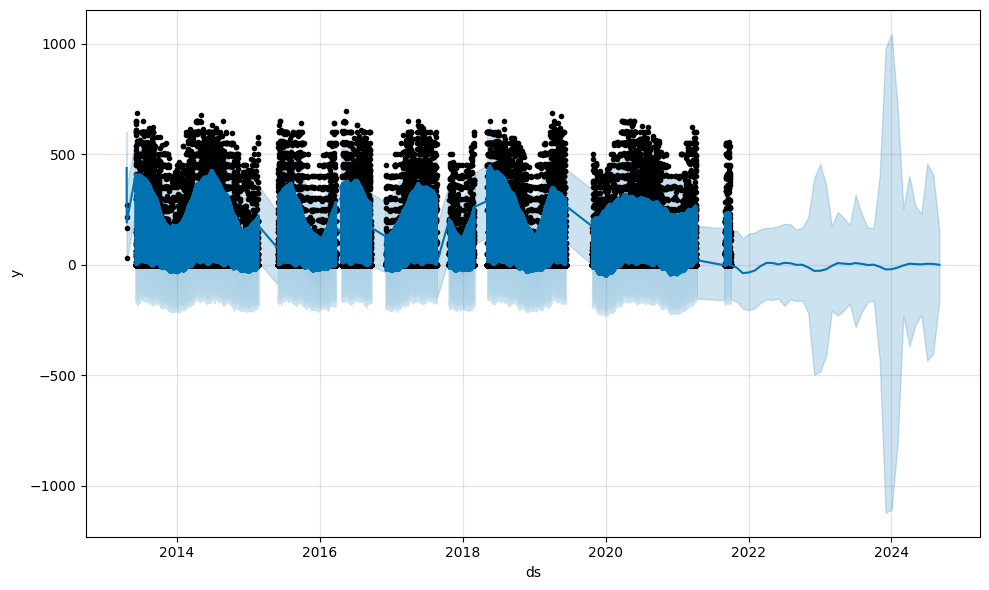

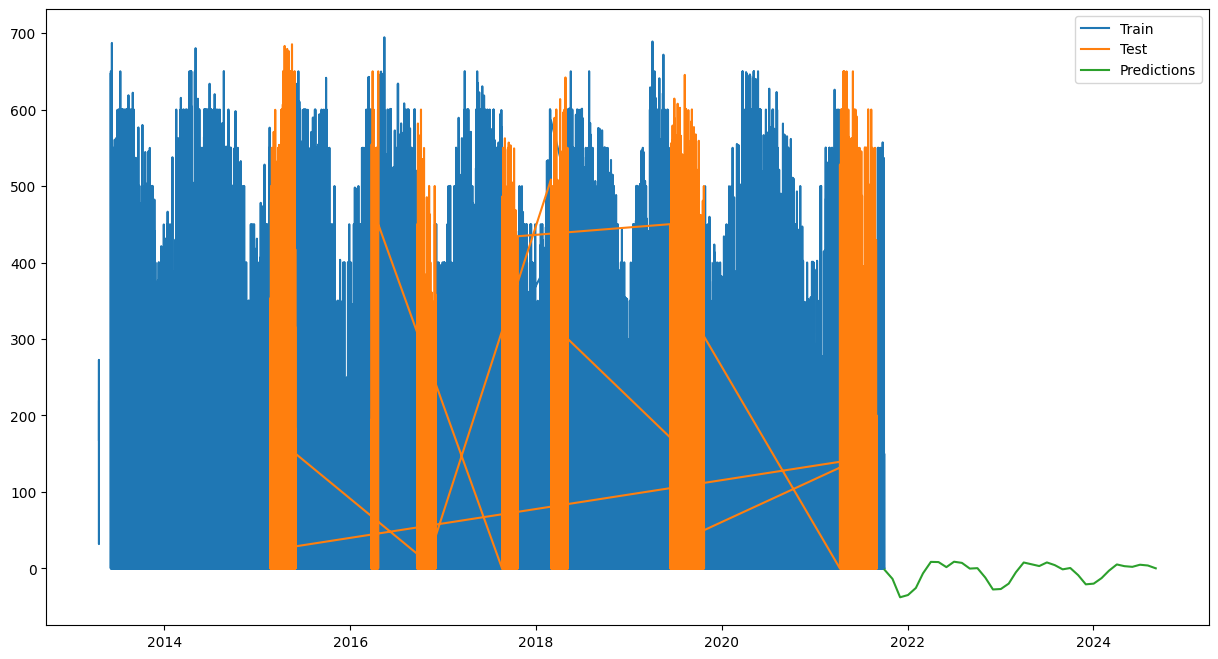

In [83]:
# Plot the prediction
ax = model.plot(forecast);
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="Predictions")
plt.legend(loc="best")

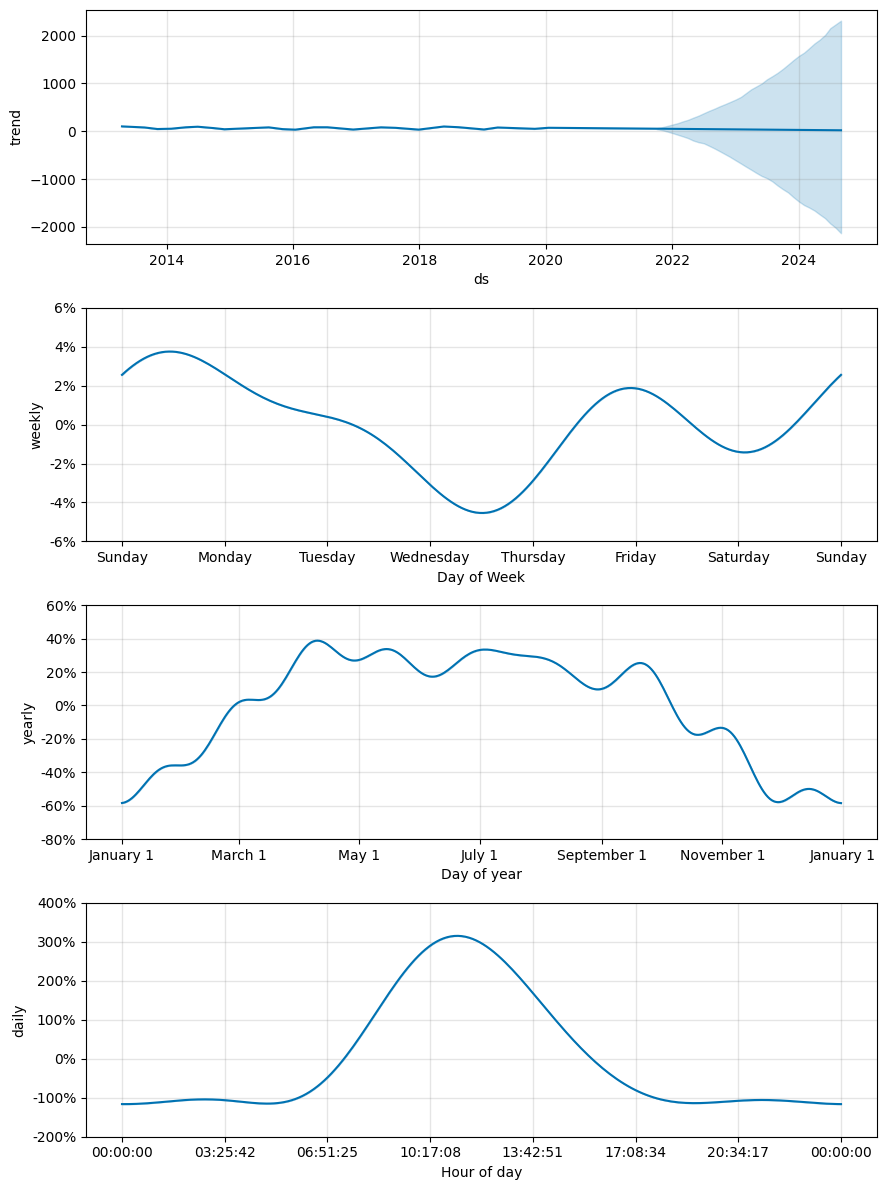

In [85]:
# Trend and seasonality
model.plot_components(forecast);